# Classificació

### Libraries and loading data

In [1]:
import pandas as pd
from sklearn.svm import SVC
from skopt import BayesSearchCV
import numpy as np
np.int = int

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from sklearn.metrics import  ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('../datasets/data_train_class7.csv')
df_test = pd.read_csv('../datasets/data_test_class7.csv')

In [3]:
df_train.head()

,BPM,Energy,Danceability,Loudness,Liveness,Valence,Length,Acousticness,Speechiness,Popularity,is_recent,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6
0,123,73,48,-8,11,87,140,57,17,65,1,0,0,0,0,1,0,0
1,99,21,34,-17,18,29,218,40,3,70,0,0,0,0,0,1,0,0
2,71,58,39,-7,22,38,295,47,3,63,0,1,0,0,0,0,0,0
3,135,23,40,-9,11,28,222,89,4,61,1,0,0,0,1,0,0,0
4,159,16,41,-22,12,42,199,88,3,77,0,0,1,0,0,0,0,0


In [4]:
x_train = df_train.drop(columns=['is_recent'])
y_train = df_train['is_recent']

x_test = df_test.drop(columns=['is_recent'])
y_test = df_test['is_recent']

clss = ['Pre-2000', 'Post-2000']

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1395.0,0.456174,0.179555,0.0,0.318471,0.452229,0.557325,1.0
1,1395.0,0.583587,0.229908,0.0,0.401042,0.604167,0.770833,1.0
2,1395.0,0.500500,0.179877,0.0,0.383721,0.500000,0.627907,1.0
3,1395.0,0.723097,0.145117,0.0,0.640000,0.760000,0.840000,1.0
4,1395.0,0.175110,0.169782,0.0,0.072165,0.103093,0.216495,1.0
5,1395.0,0.480615,0.258486,0.0,0.270833,0.458333,0.677083,1.0
6,1395.0,0.131427,0.070653,0.0,0.093407,0.118524,0.152276,1.0
7,1395.0,0.298786,0.296839,0.0,0.030612,0.183673,0.520408,1.0
8,1395.0,0.057672,0.082810,0.0,0.018868,0.037736,0.056604,1.0
9,1395.0,0.542193,0.162211,0.0,0.426966,0.561798,0.674157,1.0


## Models

In [43]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score


def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'test f1 score (0)'] = f1_score(y_test, clf.predict(X_test), pos_label=0)
    df.loc[nclf,'test f1 score (1)'] = f1_score(y_test, clf.predict(X_test), pos_label=1)
    df.loc[nclf,'test f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    # df.loc[nclf,'ROC AUC'] = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    return df

results_df = pd.DataFrame()

### SVM

In [6]:
from sklearn.model_selection import cross_val_score


param = {'C': 10**np.linspace(-3, 3, 101)}
niter = 15

lsvm = BayesSearchCV(SVC(kernel='linear', random_state=0), 
                     param, 
                     n_iter=niter, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
y_test_predicted_lsvm = lsvm.predict(x_test)
r2_lsvm_train = np.mean(cross_val_score(lsvm, x_train, y_train))
r2_lsvm_test = np.mean(cross_val_score(lsvm, x_test, y_test))

print(f'Train R2 score: {r2_lsvm_train}')
print(f'Test R2 score: {r2_lsvm_test}')

Train R2 score: 0.7455197132616489
Test R2 score: 0.7444957983193277


In [7]:
show_html(pd.DataFrame(lsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,{'C': 660.6934480075951},0.748387,1
5,{'C': 109.64781961431851},0.747670,2
12,{'C': 54.954087385762485},0.746953,3
13,{'C': 72.44359600749891},0.746953,3
14,{'C': 15.848931924611142},0.740502,5


In [44]:
print(classification_report(lsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(lsvm, x_test, y_test, 'SVM Lineal', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.82      0.77      0.80       381
   Post-2000       0.64      0.71      0.67       218

    accuracy                           0.75       599
   macro avg       0.73      0.74      0.73       599
weighted avg       0.76      0.75      0.75       599



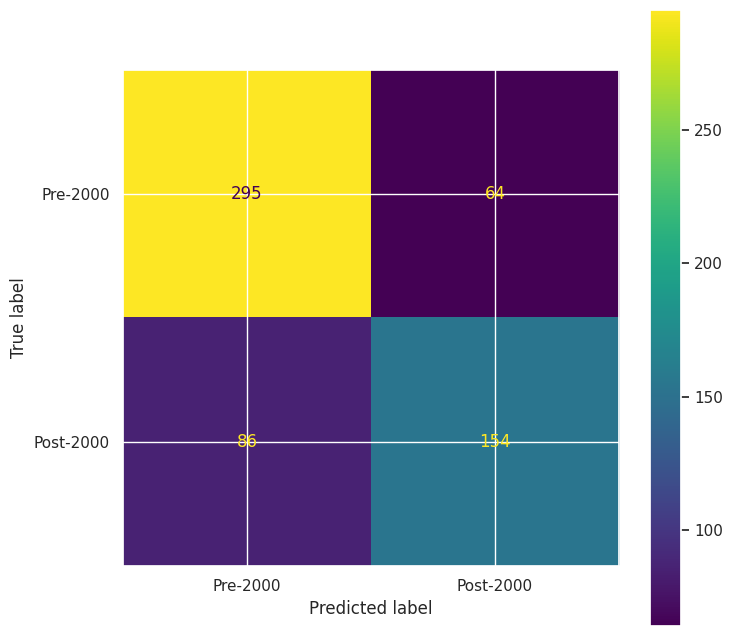

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()


plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### SVM Polinomial

In [45]:
param = {'C': 10**np.linspace(-3, 3, 101),
         'degree':[2,3]}

qsvm = BayesSearchCV(SVC(kernel='poly', random_state=0), 
                     param, 
                     n_iter=niter, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
y_test_predicted_qsvm = qsvm.predict(x_test)
r2_qsvm_train = np.mean(cross_val_score(qsvm, x_train, y_train))
r2_qsvm_test = np.mean(cross_val_score(qsvm, x_test, y_test))

print(f'Train R2 score: {r2_qsvm_train}')
print(f'Test R2 score: {r2_qsvm_test}')

Train R2 score: 0.7655913978494624
Test R2 score: 0.7178571428571429


In [ ]:
show_html(pd.DataFrame(qsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,"{'C': 5.248074602497723, 'degree': 3}",0.767742,1
7,"{'C': 1.1481536214968828, 'degree': 3}",0.762007,2
0,"{'C': 1.513561248436207, 'degree': 3}",0.761290,3
13,"{'C': 6.918309709189363, 'degree': 2}",0.760573,4
14,"{'C': 6.918309709189363, 'degree': 3}",0.759140,5


In [46]:
print(classification_report(qsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(qsvm, x_test, y_test, 'SVM Polinomic', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.77      0.80       394
   Post-2000       0.62      0.73      0.67       205

    accuracy                           0.75       599
   macro avg       0.73      0.75      0.74       599
weighted avg       0.77      0.75      0.76       599



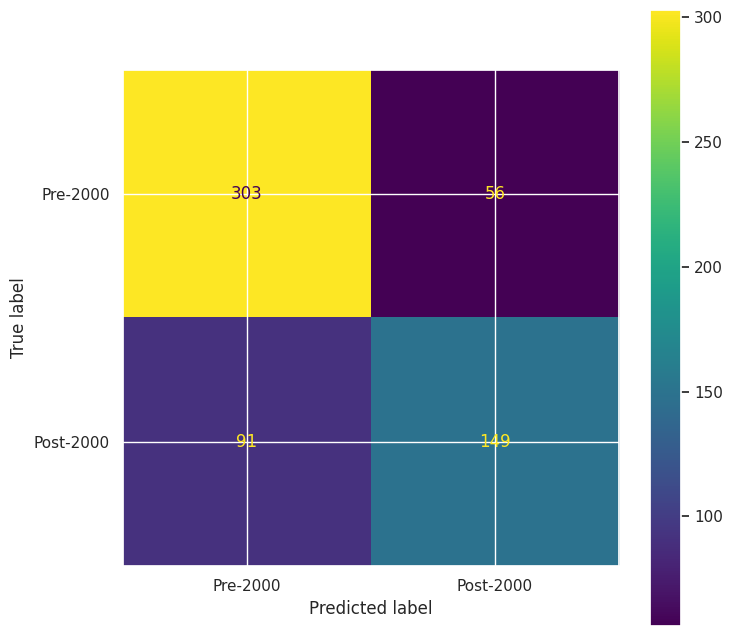

In [13]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(qsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### SVM RBF

In [14]:
param = {'C':10**np.linspace(-3,3,101), 
         'gamma':['scale','auto']}

rbfsvm = BayesSearchCV(SVC(kernel='rbf', random_state=0), 
                     param, 
                     n_iter=niter, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
y_test_predicted_rbfsvm = rbfsvm.predict(x_test)
r2_rbfsvm_train = np.mean(cross_val_score(rbfsvm, x_train, y_train))
r2_rbfsvm_test = np.mean(cross_val_score(rbfsvm, x_test, y_test))

print(f'Train R2 score: {r2_rbfsvm_train}')
print(f'Test R2 score: {r2_rbfsvm_test}')

Train R2 score: 0.7655913978494623
Test R2 score: 0.7495518207282913


In [15]:
show_html(pd.DataFrame(rbfsvm.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
10,"{'C': 109.64781961431851, 'gamma': 'auto'}",0.765591,1
11,"{'C': 109.64781961431851, 'gamma': 'auto'}",0.765591,1
12,"{'C': 6.918309709189363, 'gamma': 'scale'}",0.758423,3
13,"{'C': 6.918309709189363, 'gamma': 'auto'}",0.751971,4
5,"{'C': 109.64781961431851, 'gamma': 'scale'}",0.751254,5


In [47]:
print(classification_report(rbfsvm.predict(x_test), y_test, target_names=clss))
results_df = save_results(rbfsvm, x_test, y_test, 'SVM RBF', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.77      0.81       391
   Post-2000       0.63      0.73      0.68       208

    accuracy                           0.76       599
   macro avg       0.74      0.75      0.74       599
weighted avg       0.77      0.76      0.76       599



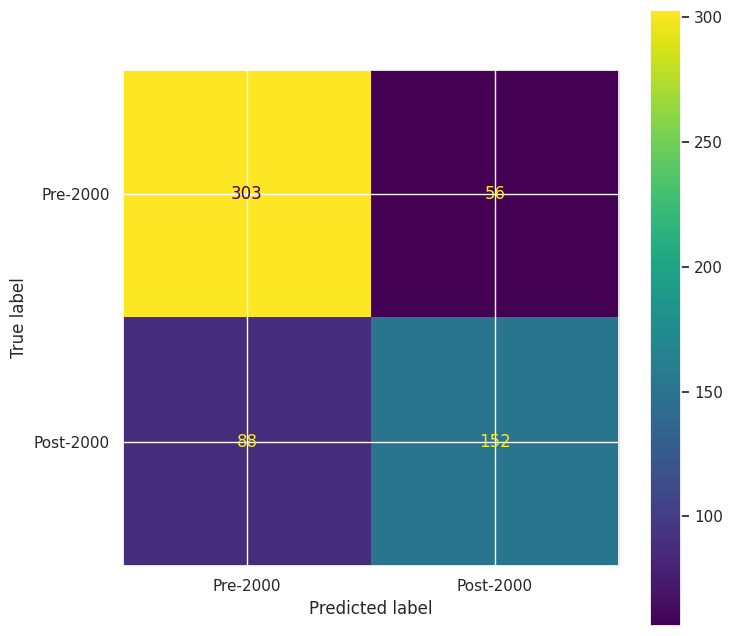

In [16]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbfsvm, x_test, y_test, display_labels=clss, ax=plt.subplot());

### KNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier


param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 
          'weights':['distance', 'uniform'], 
          'leaf_size':[1, 5, 10, 20, 30],
          'metric': ['l2', 'l1', 'cosine']}

knn = BayesSearchCV(KNeighborsClassifier(), 
                     param, 
                     n_iter=niter, 
                     n_jobs=-1, 
                     refit=True, 
                     random_state=0).fit(x_train, y_train)
y_test_predicted_knn = knn.predict(x_test)
r2_knn_train = np.mean(cross_val_score(knn, x_train, y_train))
r2_knn_test = np.mean(cross_val_score(knn, x_test, y_test))

print(f'Train R2 score: {r2_knn_train}')
print(f'Test R2 score: {r2_knn_test}')

Train R2 score: 0.7103942652329749
Test R2 score: 0.6844677871148461


In [48]:
show_html(pd.DataFrame(knn.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
7,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 11, 'weights': 'distance'}",0.723297,1
10,"{'leaf_size': 5, 'metric': 'l1', 'n_neighbors': 11, 'weights': 'uniform'}",0.719713,2
13,"{'leaf_size': 10, 'metric': 'l1', 'n_neighbors': 15, 'weights': 'distance'}",0.716129,3
5,"{'leaf_size': 20, 'metric': 'l2', 'n_neighbors': 11, 'weights': 'distance'}",0.713262,4
14,"{'leaf_size': 20, 'metric': 'l1', 'n_neighbors': 5, 'weights': 'distance'}",0.711828,5


In [49]:
print(classification_report(knn.predict(x_test), y_test, target_names=clss))
results_df = save_results(knn, x_test, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.82      0.74      0.78       397
   Post-2000       0.57      0.68      0.62       202

    accuracy                           0.72       599
   macro avg       0.69      0.71      0.70       599
weighted avg       0.74      0.72      0.72       599



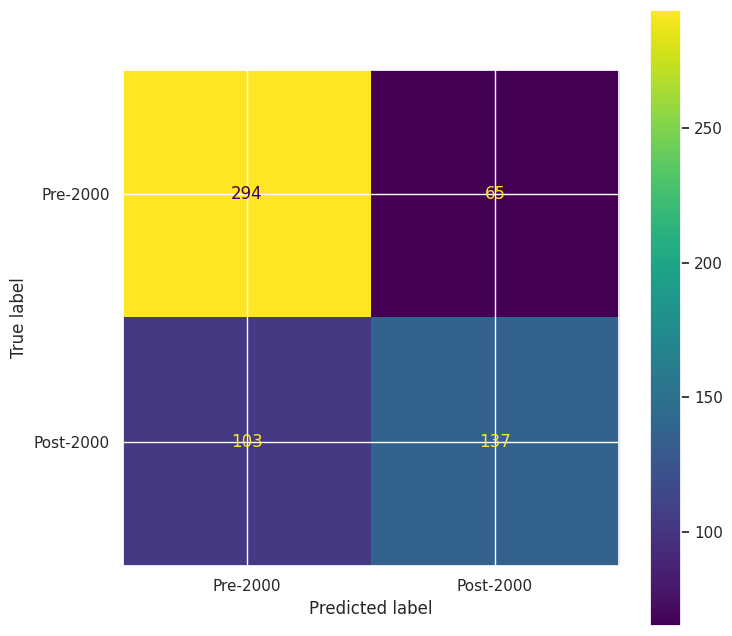

In [21]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rforest = BayesSearchCV(RandomForestClassifier(), param, n_iter=niter, n_jobs=-1, refit=True, random_state=0).fit(x_train, y_train)
y_test_predicted_rforest = rforest.predict(x_test)
r2_rforest_train = np.mean(cross_val_score(rforest, x_train, y_train))
r2_rforest_test = np.mean(cross_val_score(rforest, x_test, y_test))

print(f'Train R2 score: {r2_rforest_train}')
print(f'Test R2 score: {r2_rforest_test}')

Train R2 score: 0.7620071684587814
Test R2 score: 0.717829131652661


In [23]:
show_html(pd.DataFrame(rforest.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
3,"{'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 40}",0.770609,1
11,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 40}",0.770609,1
8,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 200}",0.769892,3
5,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 40}",0.767742,4
13,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'n_estimators': 75}",0.763441,5


In [50]:
print(classification_report(rforest.predict(x_test), y_test, target_names=clss))
results_df = save_results(rforest, x_test, y_test, 'Random Forest', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.86      0.74      0.79       419
   Post-2000       0.54      0.72      0.62       180

    accuracy                           0.73       599
   macro avg       0.70      0.73      0.71       599
weighted avg       0.76      0.73      0.74       599



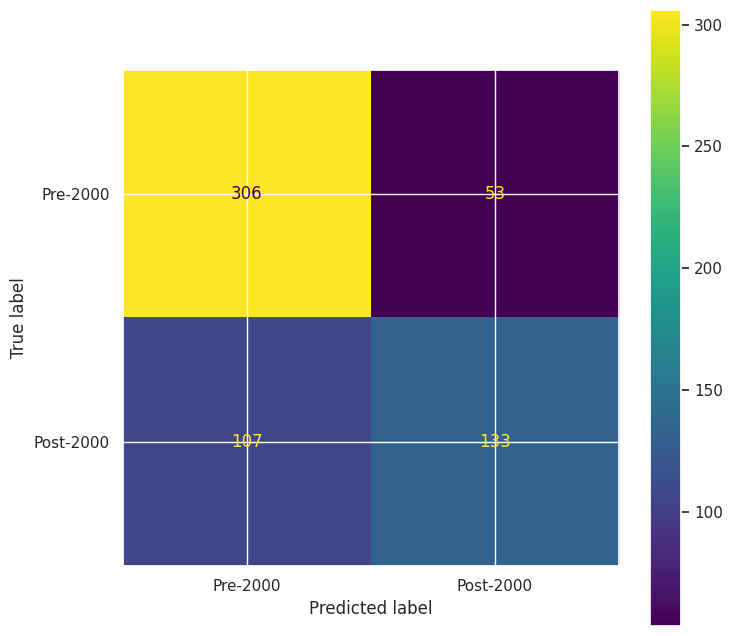

In [25]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rforest, x_test, y_test, display_labels=clss, ax=plt.subplot());

### Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier


param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gboost = BayesSearchCV(GradientBoostingClassifier(random_state=0, n_iter_no_change=5), 
                        param, 
                        n_iter=niter, 
                        n_jobs=-1, 
                        refit=True, 
                        random_state=0).fit(x_train, y_train)
y_test_predicted_gboost = gboost.predict(x_test)
r2_gboost_train = np.mean(cross_val_score(gboost, x_train, y_train))
r2_gboost_test = np.mean(cross_val_score(gboost, x_test, y_test))

print(f'Train R2 score: {r2_gboost_train}')
print(f'Test R2 score: {r2_gboost_test}')

Train R2 score: 0.7455197132616488
Test R2 score: 0.7044957983193278


In [28]:
show_html(pd.DataFrame(gboost.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.748387,1
12,"{'criterion': 'squared_error', 'learning_rate': 1.0, 'loss': 'exponential', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 25}",0.734050,2
14,"{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 75}",0.730466,3
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'min_samples_leaf': 2, 'n_estimators': 25}",0.730466,4
11,"{'criterion': 'friedman_mse', 'learning_rate': 1.0, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 10}",0.726165,5


In [51]:
print(classification_report(gboost.predict(x_test), y_test, target_names=clss))
results_df = save_results(rforest, x_test, y_test, 'Gradient Boosting', results_df)

              precision    recall  f1-score   support

    Pre-2000       0.84      0.74      0.78       409
   Post-2000       0.55      0.69      0.61       190

    accuracy                           0.72       599
   macro avg       0.69      0.72      0.70       599
weighted avg       0.75      0.72      0.73       599



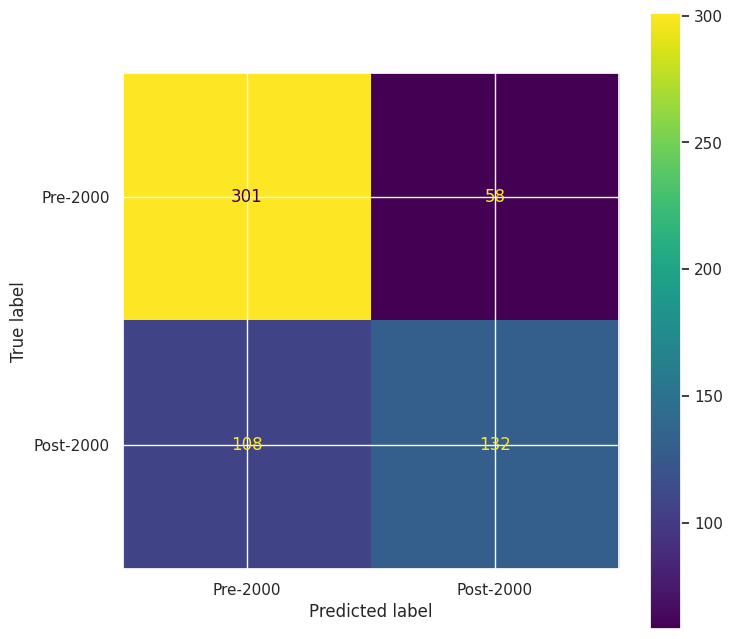

In [29]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gboost, x_test, y_test, display_labels=clss, ax=plt.subplot());

## Conclusions

In [52]:
results_sorted = results_df.sort_values(by=['test f1 score (W)'], ascending=False)
results_sorted

,train XV acc,test acc,test f1 score (0),test f1 score (1),test f1 score (W)
SVM RBF,0.765591,0.759599,0.808000,0.678571,0.743286
SVM Polinomic,0.767742,0.754591,0.804781,0.669663,0.737222
SVM Lineal,0.748387,0.749583,0.797297,0.672489,0.734893
Random Forest,0.770609,0.732888,0.794344,0.619048,0.706696
Gradient Boosting,0.770609,0.732888,0.794344,0.619048,0.706696
KNN,0.723297,0.719533,0.777778,0.619910,0.698844


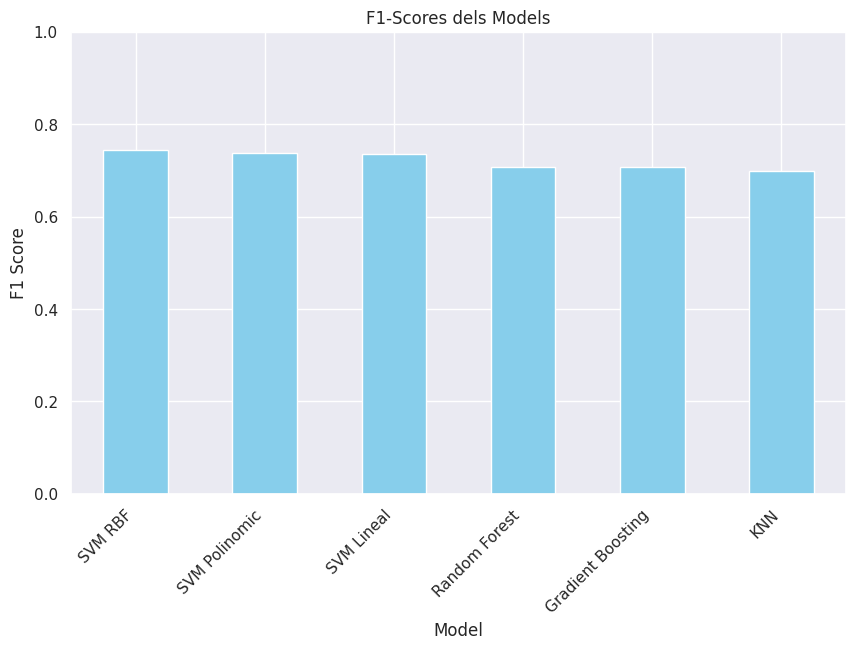

In [53]:
plt.figure(figsize=(10, 6))
results_sorted['test f1 score (W)'].plot(kind='bar', color='skyblue')
plt.title('F1-Scores dels Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')
plt.show()